# Exploratory Data Analysis

This notebook contains exploratory data analysis for the Music Clustering project.


In [ ]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import torch
import pandas as pd

# Add src to path
sys.path.append('../src')

print("Python version:", sys.version)
print("PyTorch version:", torch.__version__)


## Check Processed Data


In [ ]:
# Check if processed data exists
if os.path.exists('../processed_data.pt'):
    data = torch.load('../processed_data.pt')
    print("MFCC Features shape:", data['features'].shape)
    print("Labels shape:", data['labels'].shape)
    print("Unique labels:", torch.unique(data['labels']))
else:
    print("processed_data.pt not found. Run preprocess.py first.")


In [ ]:
# Check hybrid data
if os.path.exists('../hybrid_data.pt'):
    data = torch.load('../hybrid_data.pt')
    print("Spectrograms shape:", data['spectrograms'].shape)
    print("Text embeddings shape:", data['text_embeddings'].shape)
    print("Labels shape:", data['labels'].shape)
else:
    print("hybrid_data.pt not found. Run hybrid_data.py first.")


## Visualize Results


In [ ]:
# Load metrics if available
if os.path.exists('../results/clustering_metrics.csv'):
    df = pd.read_csv('../results/clustering_metrics.csv')
    print("Metrics DataFrame:")
    print(df)
else:
    print("clustering_metrics.csv not found. Run training scripts first.")


# Music Clustering Project - Exploratory Data Analysis

This notebook provides exploratory data analysis, quick experiments, and examples for the Music Clustering with VAE project.


In [ ]:

import sys
import os
import subprocess
from pathlib import Path

print("="*60)
print("Python Environment Info")
print("="*60)
print(f"Python executable: {sys.executable}")
print(f"Python version: {sys.version}")
print("="*60)


required_packages = {
    'numpy': 'numpy',
    'matplotlib': 'matplotlib',
    'torch': 'torch',
    'librosa': 'librosa',
    'pandas': 'pandas'
}

print("\nChecking dependencies...")
missing = []
for module_name, package_name in required_packages.items():
    try:
        __import__(module_name)
        print(f"{module_name} is installed")
    except ImportError:
        print(f"{module_name} is NOT installed")
        missing.append(package_name)

if missing:
    print("\n" + "="*60)
    print("Missing dependencies detected!")
    print("="*60)
    print(f"Current Python: {sys.executable}")
    print(f"\nInstalling missing packages: {', '.join(missing)}")
    print("This may take a few minutes...")
    print("="*60)
    
    try:
        for package in missing:
            print(f"\nInstalling {package}...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package], 
                                stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            print(f"{package} installed successfully")
        
        print("\n" + "="*60)
        print("All packages installed! Please restart the kernel and run this cell again.")
        print("="*60)
        print("\nTo restart kernel:")
        print("  - In Jupyter: Kernel → Restart")
        print("  - In VS Code: Click kernel name → Restart Kernel")
        
    except Exception as e:
        print(f"\nError installing packages: {e}")
        print("\nPlease install manually:")
        req_path = Path.cwd().parent / 'requirements.txt' if Path.cwd().name == 'notebooks' else Path.cwd() / 'requirements.txt'
        print(f"   {sys.executable} -m pip install -r {req_path}")
        raise ImportError(f"Please install missing packages: {', '.join(missing)}")
    
    import sys
    sys.exit("Please restart the kernel after installation.")

print("\nAll dependencies are installed!\n")


import numpy as np
import matplotlib.pyplot as plt
import torch
import librosa
import pandas as pd


PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = PROJECT_ROOT / 'dataset' / 'audio'
RESULTS_DIR = PROJECT_ROOT / 'results'

print(f"Project root: {PROJECT_ROOT}")
print(f"Data directory: {DATA_DIR}")
print(f"Results directory: {RESULTS_DIR}")


Python Environment Info
Python executable: c:\Users\sanch\MusicClusteringProject\.venv-1\Scripts\python.exe
Python version: 3.14.2 (tags/v3.14.2:df79316, Dec  5 2025, 17:18:21) [MSC v.1944 64 bit (AMD64)]

Checking dependencies...
✅ numpy is installed
✅ matplotlib is installed
✅ torch is installed
✅ librosa is installed
✅ pandas is installed

✅ All dependencies are installed!

Project root: c:\Users\sanch\MusicClusteringProject
Data directory: c:\Users\sanch\MusicClusteringProject\dataset\audio
Results directory: c:\Users\sanch\MusicClusteringProject\results


In [2]:
import sys
print(sys.executable)

c:\Users\sanch\MusicClusteringProject\.venv-1\Scripts\python.exe


## 1. Dataset Overview

Let's explore the dataset structure and get basic statistics.


Dataset Statistics
Total audio files: 3293

Files per language:
  Bangla      :  243 files
  English     : 1910 files
  Hindi       :  150 files
  Korean      :  318 files
  Japanese    :  389 files
  Spanish     :  283 files


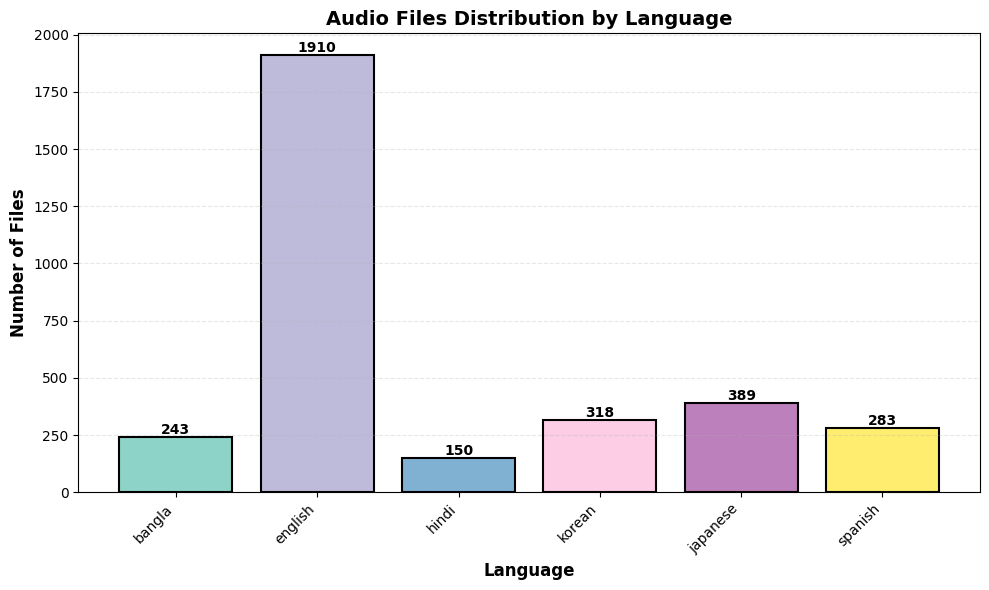

In [ ]:

languages = ['bangla', 'english', 'hindi', 'korean', 'japanese', 'spanish']
lang_map = {lang: i for i, lang in enumerate(languages)}


file_counts = {}
total_files = 0

for lang in languages:
    lang_path = DATA_DIR / lang
    if lang_path.exists():
        files = [f for f in os.listdir(lang_path) if f.endswith(('.wav', '.mp3'))]
        file_counts[lang] = len(files)
        total_files += len(files)
    else:
        file_counts[lang] = 0


print("=" * 50)
print("Dataset Statistics")
print("=" * 50)
print(f"Total audio files: {total_files}")
print("\nFiles per language:")
for lang, count in file_counts.items():
    print(f"  {lang.capitalize():12s}: {count:4d} files")
print("=" * 50)


fig, ax = plt.subplots(figsize=(10, 6))
langs = list(file_counts.keys())
counts = list(file_counts.values())
colors = plt.cm.Set3(np.linspace(0, 1, len(langs)))

bars = ax.bar(langs, counts, color=colors, edgecolor='black', linewidth=1.5)
ax.set_xlabel('Language', fontsize=12, fontweight='bold')
ax.set_ylabel('Number of Files', fontsize=12, fontweight='bold')
ax.set_title('Audio Files Distribution by Language', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')


for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontweight='bold')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


## 2. Sample Audio Analysis

Let's examine a few sample audio files to understand their characteristics.


In [ ]:

samples = {}
for lang in languages:
    lang_path = DATA_DIR / lang
    if lang_path.exists():
        files = [f for f in os.listdir(lang_path) if f.endswith(('.wav', '.mp3'))]
        if files:
            sample_file = lang_path / files[0]
            try:
                y, sr = librosa.load(str(sample_file), duration=10)  
                samples[lang] = {'audio': y, 'sr': sr, 'file': files[0]}
            except Exception as e:
                print(f"Error loading {lang}: {e}")

print(f"Loaded {len(samples)} sample files")


Loaded 6 sample files


C:\Users\sanch\AppData\Local\Temp\ipykernel_9132\972139999.py:33: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\sanch\AppData\Local\Temp\ipykernel_9132\972139999.py:33: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\sanch\AppData\Local\Temp\ipykernel_9132\972139999.py:33: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\sanch\AppData\Local\Temp\ipykernel_9132\972139999.py:33: UserWarning: Glyph 50500 (\N{HANGUL SYLLABLE A}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\sanch\AppData\Local\Temp\ipykernel_9132\972139999.py:33: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\sanch\AppData\Local\Temp\ipykernel_9132\972139999.py:33: UserWarning: Glyph 46308 (\N{HANGUL SYLLABLE DEUL}) missing from font(s) De

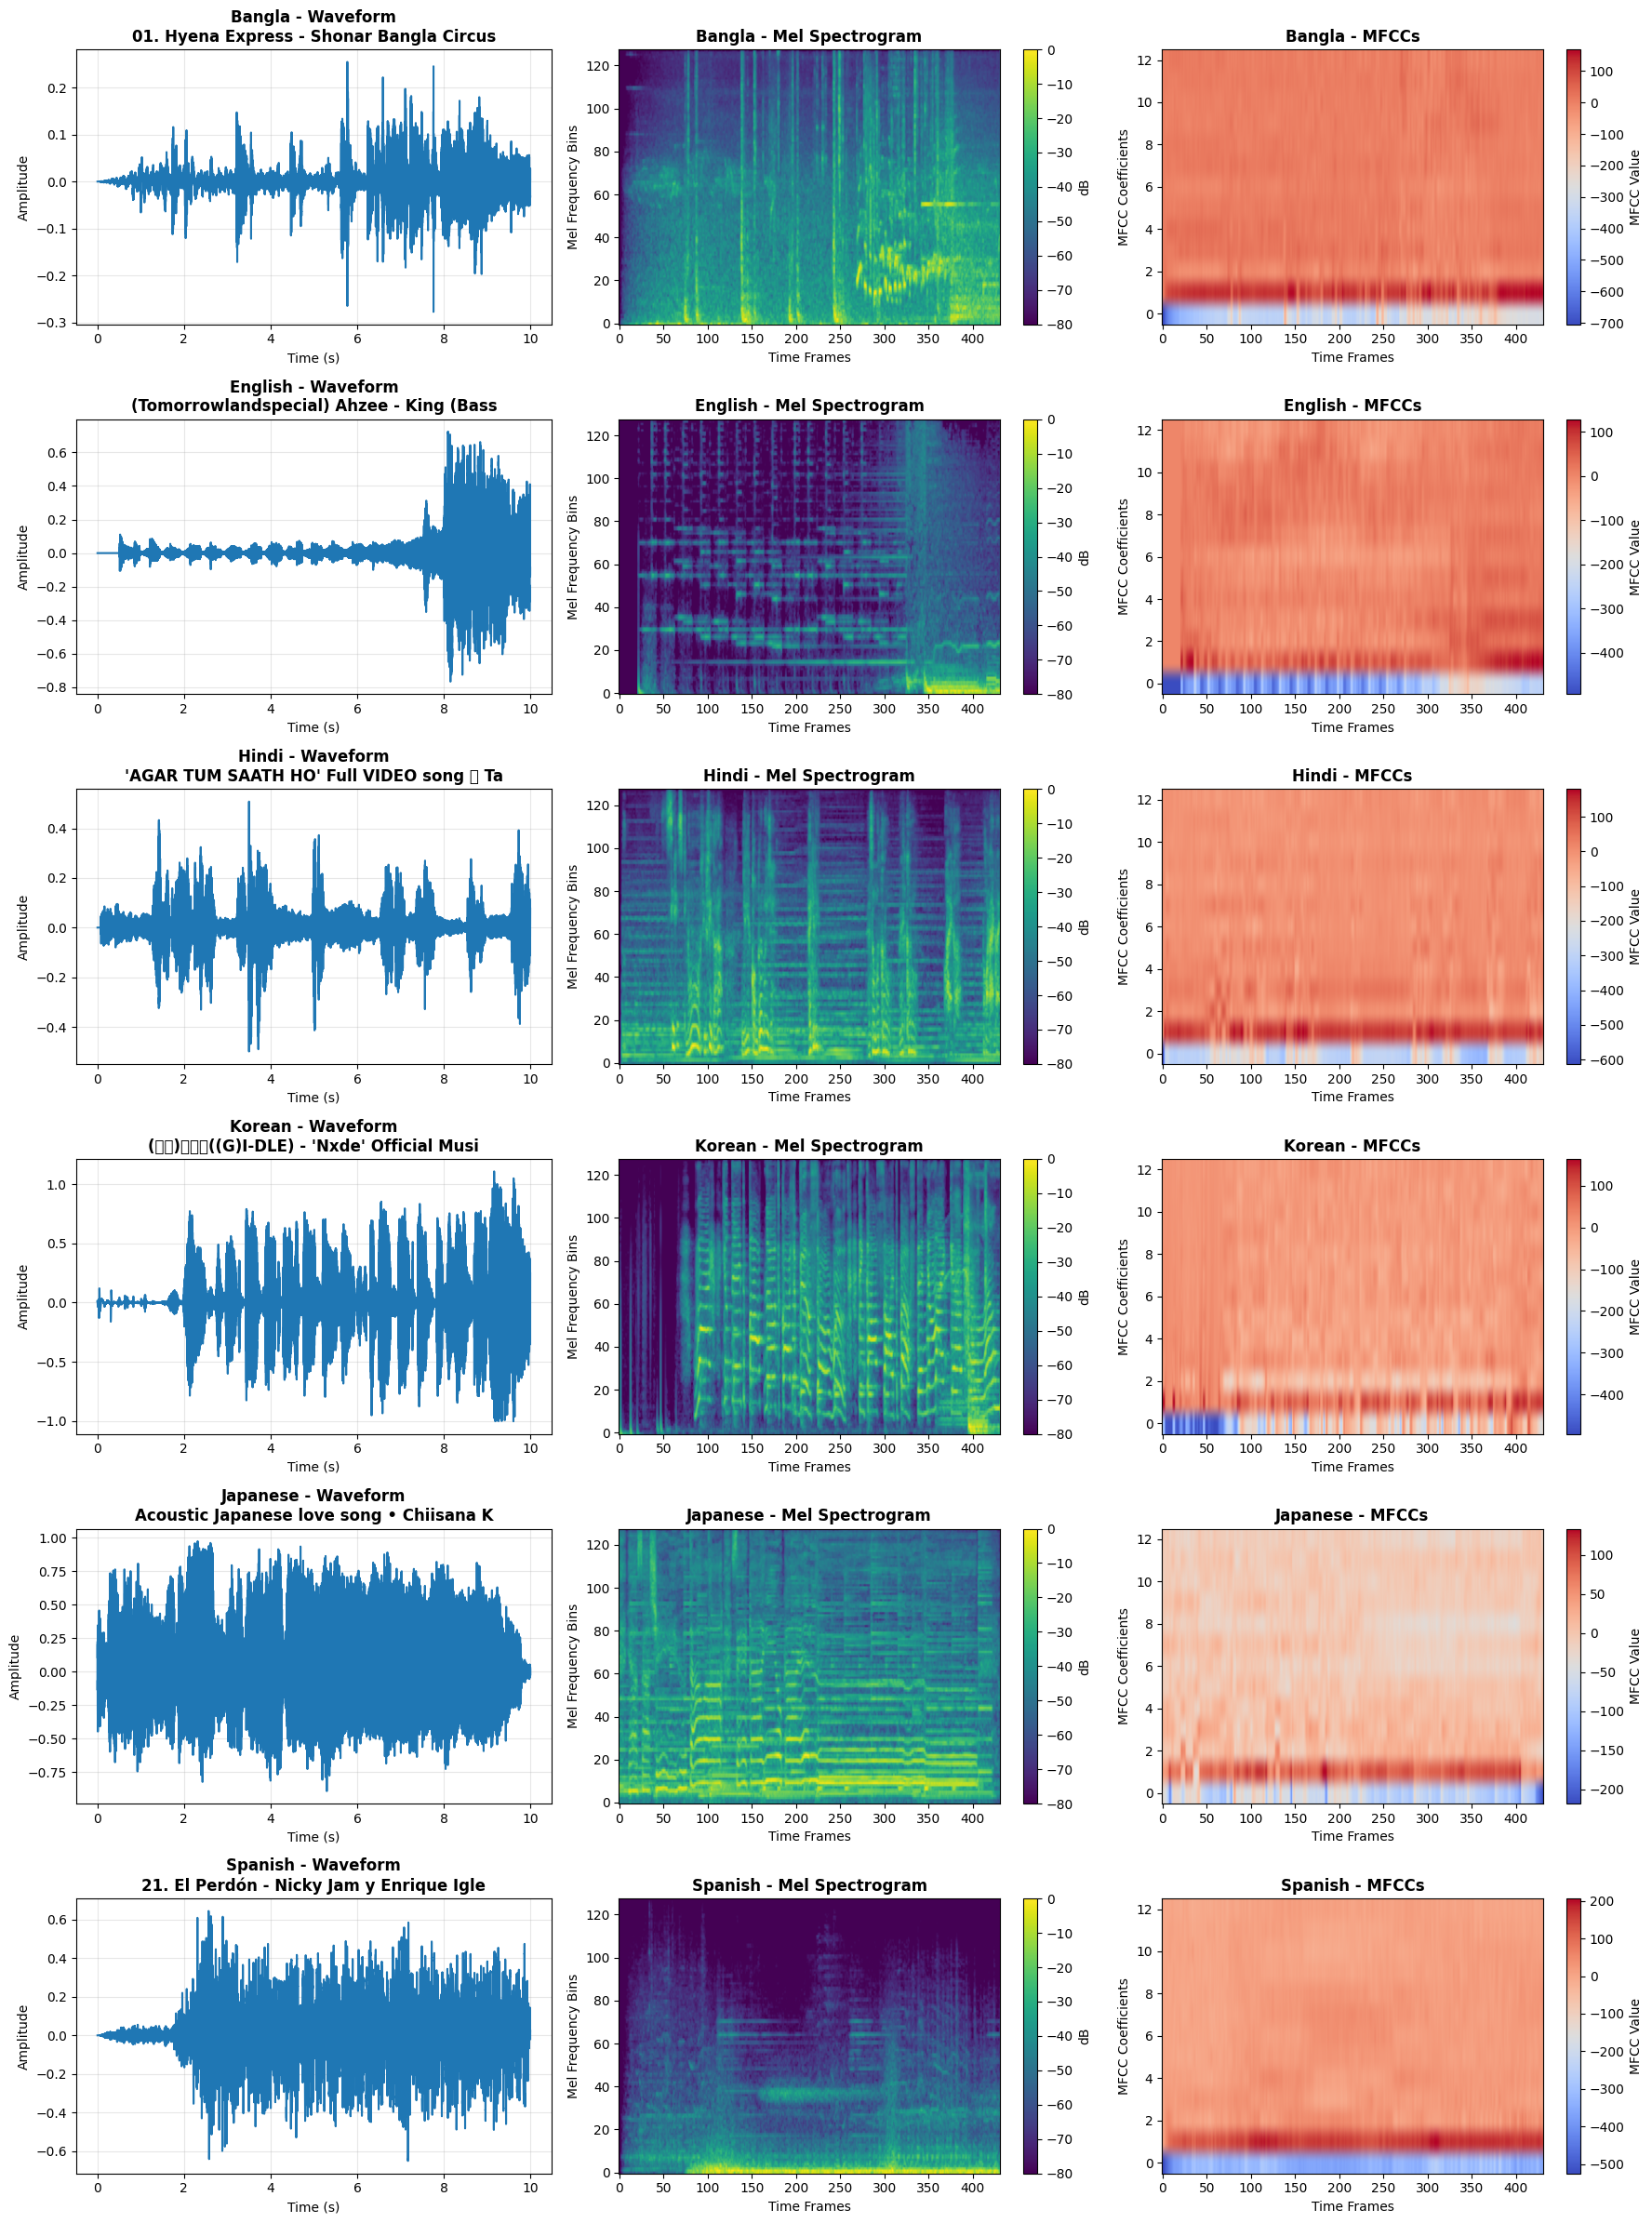

In [ ]:

n_samples = len(samples)
fig, axes = plt.subplots(n_samples, 3, figsize=(18, 4*n_samples))

for idx, (lang, data) in enumerate(samples.items()):
    y = data['audio']
    sr = data['sr']
    
    
    axes[idx, 0].plot(np.linspace(0, len(y)/sr, len(y)), y)
    axes[idx, 0].set_title(f'{lang.capitalize()} - Waveform\n{data["file"][:40]}', fontweight='bold')
    axes[idx, 0].set_xlabel('Time (s)')
    axes[idx, 0].set_ylabel('Amplitude')
    axes[idx, 0].grid(alpha=0.3)
    
    
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    S_DB = librosa.power_to_db(S, ref=np.max)
    im = axes[idx, 1].imshow(S_DB, aspect='auto', origin='lower', cmap='viridis')
    axes[idx, 1].set_title(f'{lang.capitalize()} - Mel Spectrogram', fontweight='bold')
    axes[idx, 1].set_xlabel('Time Frames')
    axes[idx, 1].set_ylabel('Mel Frequency Bins')
    plt.colorbar(im, ax=axes[idx, 1], label='dB')
    
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    im = axes[idx, 2].imshow(mfccs, aspect='auto', origin='lower', cmap='coolwarm')
    axes[idx, 2].set_title(f'{lang.capitalize()} - MFCCs', fontweight='bold')
    axes[idx, 2].set_xlabel('Time Frames')
    axes[idx, 2].set_ylabel('MFCC Coefficients')
    plt.colorbar(im, ax=axes[idx, 2], label='MFCC Value')

plt.tight_layout()
plt.show()


## 3. Load and Explore Processed Data

Let's check the preprocessed data files.


In [ ]:

processed_files = {
    'Easy Task (MFCC)': PROJECT_ROOT / 'processed_data.pt',
    'Medium/Hard Task (Spectrograms)': PROJECT_ROOT / 'processed_data_2d_labeled.pt',
    'Hybrid Data': PROJECT_ROOT / 'hybrid_data.pt'
}

for name, path in processed_files.items():
    if path.exists():
        data = torch.load(path)
        print(f"\n{name}:")
        print(f"  File: {path.name}")
        if isinstance(data, dict):
            for key, value in data.items():
                if isinstance(value, torch.Tensor):
                    print(f" {key}: shape {value.shape}, dtype {value.dtype}")
                else:
                    print(f" {key}: {type(value).__name__}")
        else:
            print(f"  Shape: {data.shape}, dtype: {data.dtype}")
    else:
        print(f"\n{name}: File not found at {path}")



Easy Task (MFCC):
  File: processed_data.pt
  Shape: torch.Size([3413, 13]), dtype: torch.float32

Medium/Hard Task (Spectrograms):
  File: processed_data_2d_labeled.pt
    data: shape torch.Size([3293, 1, 128, 128]), dtype torch.float32
    labels: shape torch.Size([3293]), dtype torch.int64

Hybrid Data:
  File: hybrid_data.pt
    audio: shape torch.Size([3293, 1, 128, 128]), dtype torch.float32
    text: shape torch.Size([3293, 384]), dtype torch.float32
    labels: shape torch.Size([3293]), dtype torch.int64


## 4. Explore Clustering Results

Let's visualize the saved clustering results and metrics.


In [ ]:

import pandas as pd


metrics_file = RESULTS_DIR / 'clustering_metrics.csv'
if metrics_file.exists():
    metrics_df = pd.read_csv(metrics_file)
    print("Clustering Metrics:")
    print("=" * 80)
    print(metrics_df.to_string(index=False))
    print("=" * 80)
else:
    print("Metrics file not found. Run training scripts first.")


Clustering Metrics:
                   method   task  silhouette_score  calinski_harabasz_index  davies_bouldin_index  adjusted_rand_index      nmi  cluster_purity     algorithm
                      NaN medium          0.052613               144.509649              3.096145             0.084833 0.064992        0.580018        kmeans
                      NaN medium          0.035053               111.170772              3.698797             0.086894 0.053657        0.581840 agglomerative
           CVAE + K-Means   hard          0.087176               172.099772              2.882458             0.145093 0.060169        0.580018           NaN
    Autoencoder + K-Means   hard          0.196663               750.655242              1.807611             0.119821 0.055624        0.580018           NaN
            PCA + K-Means   hard          0.231671              1210.699481              1.522690             0.101236 0.052251        0.580018           NaN
Direct Spectral + K-Means   hard


Available visualizations (8 files):
  - easy_clusters.png
  - hard_cluster_distribution.png
  - hard_latent_comparison.png
  - hard_reconstructions.png
  - hybrid_clusters.png
  - medium_clustering_comparison.png
  - medium_comparison.png
  - medium_comparison_plot.png


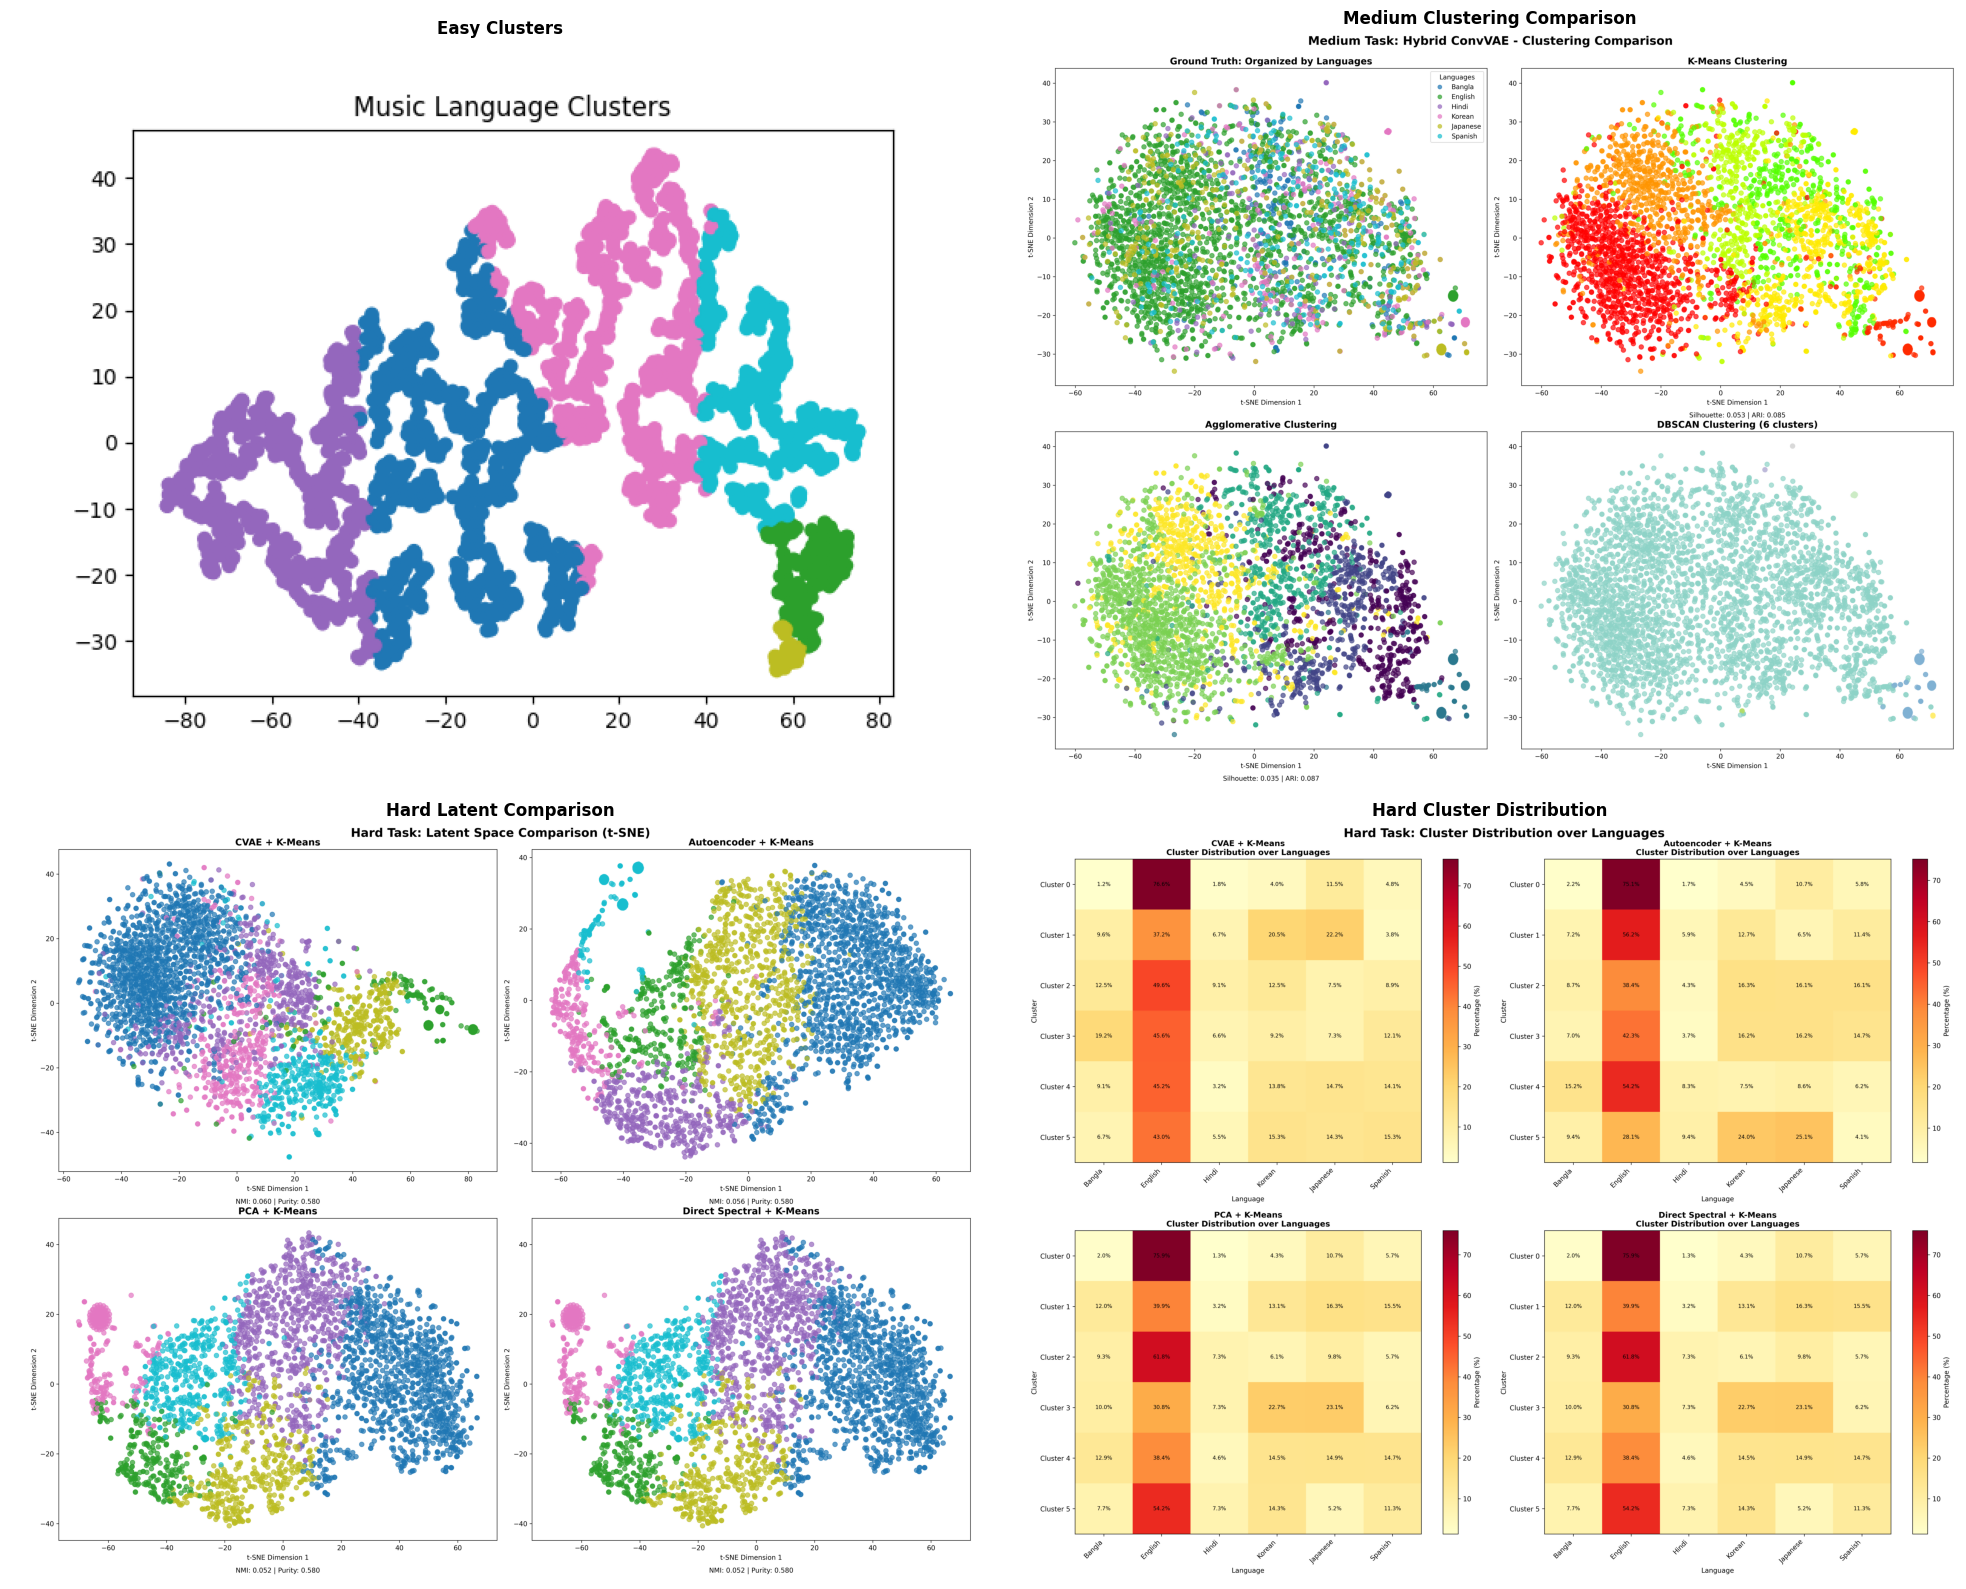

In [ ]:

viz_dir = RESULTS_DIR / 'latent_visualization'
if viz_dir.exists():
    viz_files = list(viz_dir.glob('*.png'))
    print(f"\nAvailable visualizations ({len(viz_files)} files):")
    for viz_file in sorted(viz_files):
        print(f"  - {viz_file.name}")
        

    key_viz = ['easy_clusters.png', 'medium_clustering_comparison.png', 
               'hard_latent_comparison.png', 'hard_cluster_distribution.png']
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    axes = axes.flatten()
    
    for idx, viz_name in enumerate(key_viz):
        viz_path = viz_dir / viz_name
        if viz_path.exists():
            img = plt.imread(viz_path)
            axes[idx].imshow(img)
            axes[idx].set_title(viz_name.replace('.png', '').replace('_', ' ').title(), 
                              fontsize=12, fontweight='bold')
            axes[idx].axis('off')
        else:
            axes[idx].text(0.5, 0.5, f'{viz_name}\nnot found', 
                          ha='center', va='center', transform=axes[idx].transAxes)
            axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Visualization directory not found.")


## 5. Quick Model Testing

Example of how to load and test a trained model.


In [ ]:

try:
    hybrid_data = torch.load(PROJECT_ROOT / 'hybrid_data.pt')
    
    print("Hybrid Data Structure:")
    print("=" * 50)
    for key, value in hybrid_data.items():
        if isinstance(value, torch.Tensor):
            print(f"{key:15s}: shape {str(value.shape):20s} dtype {value.dtype}")
        else:
            print(f"{key:15s}: {type(value).__name__}")

    if 'audio' in hybrid_data:
        audio = hybrid_data['audio']
        print(f"\nAudio Statistics:")
        print(f"  Min: {audio.min():.4f}, Max: {audio.max():.4f}")
        print(f"  Mean: {audio.mean():.4f}, Std: {audio.std():.4f}")
    
    if 'labels' in hybrid_data:
        labels = hybrid_data['labels']
        unique, counts = torch.unique(labels, return_counts=True)
        print(f"\nLabel Distribution:")
        for lang_id, count in zip(unique, counts):
            lang_name = languages[lang_id] if lang_id < len(languages) else f"Unknown({lang_id})"
            print(f"  {lang_name:12s}: {count.item():4d} samples")
            
except FileNotFoundError:
    print("hybrid_data.pt not found. Run src/hybrid_data.py first.")
except Exception as e:
    print(f"Error loading data: {e}")


Hybrid Data Structure:
audio          : shape torch.Size([3293, 1, 128, 128]) dtype torch.float32
text           : shape torch.Size([3293, 384]) dtype torch.float32
labels         : shape torch.Size([3293])   dtype torch.int64

Audio Statistics:
  Min: 0.0000, Max: 1.0000
  Mean: 0.3773, Std: 0.2454

Label Distribution:
  bangla      :  243 samples
  english     : 1910 samples
  hindi       :  150 samples
  korean      :  318 samples
  japanese    :  389 samples
  spanish     :  283 samples


## 6. Feature Comparison

Compare different feature extraction methods.


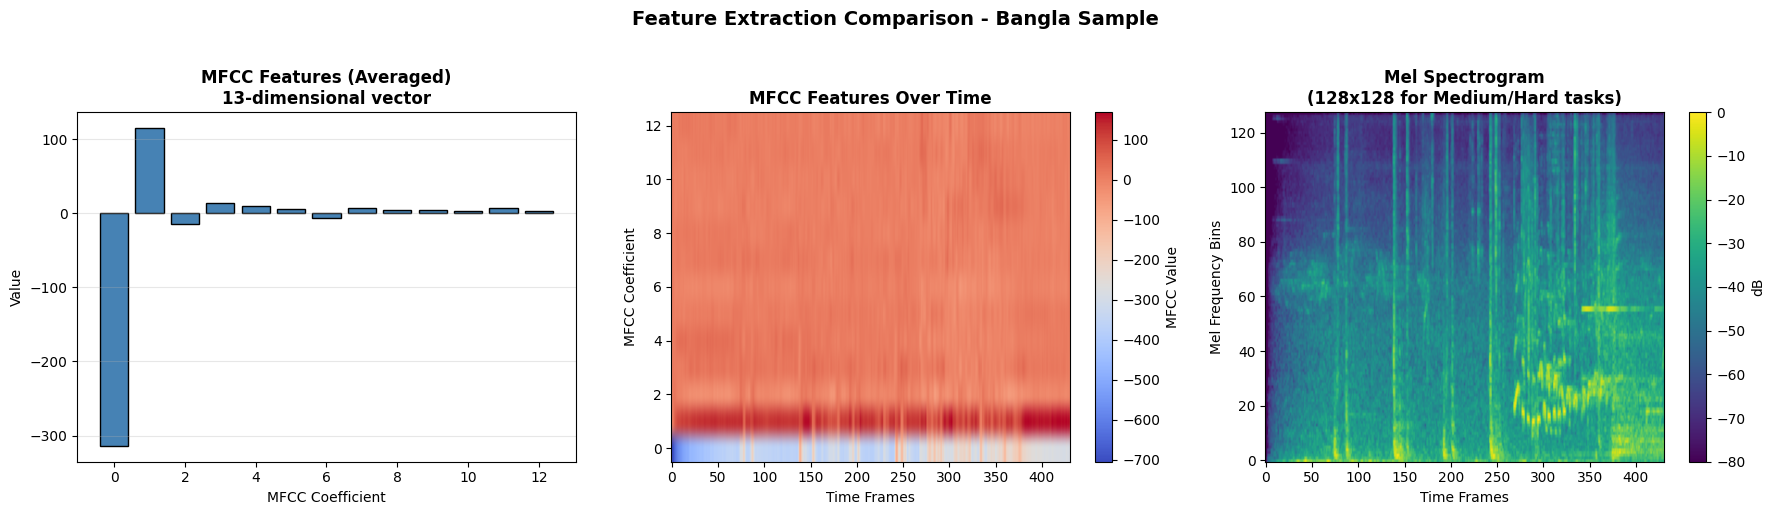


Feature Dimensions:
  MFCC (averaged): (13,) - Used in Easy Task
  MFCC (full): (13, 431) - Time-varying features
  Mel Spectrogram: (128, 431) - Used in Medium/Hard Tasks


In [ ]:

if samples:
    lang = list(samples.keys())[0]
    y = samples[lang]['audio']
    sr = samples[lang]['sr']
    
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfcc, axis=1)  
    
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    
    axes[0].bar(range(len(mfcc_mean)), mfcc_mean, color='steelblue', edgecolor='black')
    axes[0].set_title('MFCC Features (Averaged)\n13-dimensional vector', fontweight='bold')
    axes[0].set_xlabel('MFCC Coefficient')
    axes[0].set_ylabel('Value')
    axes[0].grid(axis='y', alpha=0.3)
    

    im1 = axes[1].imshow(mfcc, aspect='auto', origin='lower', cmap='coolwarm')
    axes[1].set_title('MFCC Features Over Time', fontweight='bold')
    axes[1].set_xlabel('Time Frames')
    axes[1].set_ylabel('MFCC Coefficient')
    plt.colorbar(im1, ax=axes[1], label='MFCC Value')
    
    
    im2 = axes[2].imshow(mel_spec_db, aspect='auto', origin='lower', cmap='viridis')
    axes[2].set_title('Mel Spectrogram\n(128x128 for Medium/Hard tasks)', fontweight='bold')
    axes[2].set_xlabel('Time Frames')
    axes[2].set_ylabel('Mel Frequency Bins')
    plt.colorbar(im2, ax=axes[2], label='dB')
    
    plt.suptitle(f'Feature Extraction Comparison - {lang.capitalize()} Sample', 
                 fontsize=14, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    print(f"\nFeature Dimensions:")
    print(f"  MFCC (averaged): {mfcc_mean.shape} - Used in Easy Task")
    print(f"  MFCC (full): {mfcc.shape} - Time-varying features")
    print(f"  Mel Spectrogram: {mel_spec_db.shape} - Used in Medium/Hard Tasks")


## Summary

This notebook provides:
- Dataset overview and statistics
- Sample audio analysis and visualization
- Processed data exploration
- Clustering results visualization
- Feature extraction comparison

**Next Steps:**
1. Run preprocessing scripts: `src/preprocess.py` and `src/preprocess2.py`
2. Create hybrid data: `src/hybrid_data.py`
3. Train models: `src/train.py`, `src/train_medium.py`, `src/train_hard.py`
4. Check results in `results/` directory
